In [2]:
import numpy as np
import pandas as pd

### METHODS

In [ ]:
def getEntropy(data,Y,X=None,Xgiven=None):
    ''' 
    Calculates the conditional entropyies of the form H(Y), H(Y|X), H(Y|X1=x1,...,Xj=xj) and H(Y|Xi=xi,Xj=xj,X)
    INPUT: data : mxn numpy array of data
            Y: Index of the target vairable. 0<=Y<n
            X: The conditional vairable. 0<=X<n
            Xgiven = [(X1,x1),(X2,x2),....,(Xj,xj)]
    OUTPUT: H(Y|Xi=xi,...,Xj=xj,X)
    '''
    Ndata = data.shape[0]
    Yvalues = np.unique(data[:,Y])
    N_Yvalues = Yvalues.size
    
    if X==None and Xgiven==None: # Calculate the self-entropy H(Y)
        N=Ndata
        pYgivenX = np.zeros(N_Yvalues)
        for i in range(N_Yvalues):
            pYgivenX[i] = ((data[:,Y]==Yvalues[i]).sum())/N       
        HY = -pYgivenX.dot(np.log2(pYgivenX))
    elif Xgiven == None and X!=None: # Calculate simple conditional-entropy, H(Y|X)
        Xvalues = np.unique(data[:,X])
        N_Xvalues = Xvalues.size
        HY_givenX = np.zeros(N_Xvalues)
        pX = np.zeros(N_Xvalues)

        for i in range(N_Xvalues):            
            data_givenX = data[(data[:,X]==Xvalues[i])]
            pX[i] = ((data[:,X]==Xvalues[i]).sum())/Ndata
            Nx = data_givenX.shape[0]
            pYgivenX = np.zeros(N_Yvalues)
            for j in range(N_Yvalues):
                pYgivenX[j] = ((data_givenX[:,Y]==Yvalues[j]).sum())/Nx
            
            with np.errstate(divide='ignore'):
                logProb = np.log2(pYgivenX)
            logProb[np.isneginf(logProb)]=0
            HY_givenX[i] = -pYgivenX.dot(logProb)
        
        HY = pX.dot(HY_givenX)
    
    elif Xgiven!=None and X==None:# Calculate the conditional-entropy given some observations H(Y|X1=x1,...Xn=x)        
        HY_givenX = 0        
        data_filtered = data
        for x_given in Xgiven:
            data_temp = data_filtered[(data_filtered[:,x_given[0]]==x_given[1])]    
            data_filtered = data_temp        
        Ndata = data_filtered.shape[0]                                
        pYgivenX = np.zeros(N_Yvalues)
        
        for i in range(N_Yvalues):
            pYgivenX[i] = ((data_filtered[:,Y]==Yvalues[i]).sum())/Ndata
        
        with np.errstate(divide='ignore'):
            logProb = np.log2(pYgivenX)
        logProb[np.isneginf(logProb)]=0
        HY_givenX = -pYgivenX.dot(logProb)
        
        HY = HY_givenX
                
    
    else:# Calculate the conditional-entropy H(Y|Xi=xi,...,X)        
        Xvalues = np.unique(data[:,X])
        N_Xvalues = Xvalues.size
        HY_givenX = np.zeros(N_Xvalues)
        pX = np.zeros(N_Xvalues)

        data_filtered = data
        for x_given in Xgiven:
            data_temp = data_filtered[(data_filtered[:,x_given[0]]==x_given[1])]    
            data_filtered = data_temp
        
        Ndata = data_filtered.shape[0]        
        for i in range(N_Xvalues):                          
            data_givenX = data_filtered[(data_filtered[:,X]==Xvalues[i])]
            pX[i] = ((data_filtered[:,X]==Xvalues[i]).sum())/Ndata
            Nx = data_givenX.shape[0]            
            pYgivenX = np.zeros(N_Yvalues)
            for j in range(N_Yvalues):                
                if Nx == 0 :
                    pYgivenX[j]=0
                else:
                    pYgivenX[j] = ((data_givenX[:,Y]==Yvalues[j]).sum())/Nx
            
            with np.errstate(divide='ignore'):
                logProb = np.log2(pYgivenX)
            logProb[np.isneginf(logProb)]=0
            HY_givenX[i] = -pYgivenX.dot(logProb)
        
        HY = pX.dot(HY_givenX)
        
        
                
    return HY

In [ ]:
def findRoot(data,labelId,cols):
    '''
    Finds the root feature for the decision tree
    INPUT:  data - mxn numpy array of data , n = nFeatures + 1 (target)
            labelId - the id of the target/label
            cols - The names of all the n columns
    OUTPUT: root- the id of the root feature
    '''
    HY = getEntropy(data,Y=labelId)
    print('CONDITIONAL ENTROPIES: ')
    print(f'H(Y): {HY}')
    Nfeatures = len(cols)-1
    HY_Given_Feature = np.zeros(Nfeatures)
    for i in range(Nfeatures):
        HY_Given_Feature[i] = getEntropy(data,Y=labelId,X=i)
        print(f'H(Y|{columnNames[i]}) : {HY_Given_Feature[i]}')
    
    print('\nINFORMATION GAINS: ')

    for i in range(Nfeatures):    
        print(f'I(Y;{cols[i]}) : {HY- HY_Given_Feature[i]}')

    root = np.argmin(HY_Given_Feature)
    print(f'root : {root}')
    print(f'\nRoot feature: {cols[root]}')
    
    return root

In [ ]:
def findNextNode(data,currentNode,featureSpace,labelId,treeChildren):
    '''
    Given filtered data and a feature/node, finds the next features in the decision tree for all values of the node/feature
    INPUT:  data - mxn numpy array of filtered data , n = nFeatures + 1 (target)
            currentNode - this is the feature/node where we are currently. The tree has been built for all levels above this node.
            labelId - the id of the target/label
            cols - The names of all the n columns
    OUTPUT: treeChildren - the coded version of the tree.
            treeChildren[currentNode][i] = j if feature j is the next feature when currentNode = i, given the path from the root of the tree to currentRoot
            treeChildren[currentNode][i] = +-111 if the target label is 1/0 resp,when currentNode = i, given the path from the root of the tree to currentRoot
            treeChildren[currentNode][i] = -1 if currentNode does not take the value i
    '''
    Nfeatures = len(featureSpace)
    remainingFeatures = list(range(Nfeatures))
    remainingFeatures.remove(currentNode)
    for i in range(len(featureSpace[currentNode])):
        print(f'\nFINDING THE NEXT FEATURE TO CHECK AFTER {columnNames[currentNode]}={featureSpace[currentNode][i]}')
        currentNodeValues = featureSpace[currentNode]
        NcurrentFatures = len(currentNodeValues)
        given=[(currentNode,i)]        
        HY = getEntropy(data,Y=labelId,X=None,Xgiven=given)
        M=100
        HY_Given_Feature = M*np.ones(len(remainingFeatures))
        print('CONDITIONAL ENTROPIES: ')
        print(f'H(Y|{columnNames[currentNode]} = {currentNodeValues[i]}): {HY}')
        if HY>0:
            for f in range(len(remainingFeatures)): 
                featureId = remainingFeatures[f]
                HY_Given_Feature[f] = getEntropy(data,Y=4,X=featureId,Xgiven=given)
                print(f'H(Y|{columnNames[currentNode]} = {currentNodeValues[i]},{columnNames[featureId]}) : {HY_Given_Feature[f]}')    
    
            print('INFORMATION GAINS: ')
            for f in range(len(remainingFeatures)): 
                featureId = remainingFeatures[f]
                print(f'I(Y;{columnNames[featureId]} = {currentNodeValues[i]},{columnNames[featureId]}) : {HY - HY_Given_Feature[f]}')
        
            nextNode = remainingFeatures[np.argmin(HY_Given_Feature)]
            print(f'Next Node after {columnNames[currentNode]}= {featureSpace[currentNode][i]}: {columnNames[nextNode]} ')
            treeChildren[currentNode,i] = nextNode
    
        elif HY==0:
            m = np.argwhere(data[:,currentNode]==i)[0,0]
            res = data[m,4]
            print(f'Leaf node! Decision: {res}')
            if res == 1:
                treeChildren[currentNode,i] = 111
            else:
                treeChildren[currentNode,i] = -111
    
    return treeChildren     


In [ ]:
def predict(x,root,children):
    '''
    returns a prediction based on an input instance x
    INPUT: x- an instance
           root - the root of the tree
           children - the tree coded as a 2D nummpy array 
    OUTPUT: 0/1
    '''
    pred = None
    while pred!=111 and pred!= -111:
        res = int(children[root,x[root]])
        if res == 111 or res == -111:
            pred = res
        else:
            root = res
    return pred

In [3]:
def getErrorRate(y_pred,y_actual):
    '''Finds the rate of misclassification
    '''
    return (y_pred-y_actual).sum()/y_actual.size

### LOAD AND FORMAT DATA

In [4]:
csv_path = "titanic.csv"
data = pd.read_csv(csv_path)

In [ ]:
#Let's look at a few records to see what they look like - interested in finding out column names, feature types
data.head(3)

In [ ]:
# Interested in feature types and range
data.describe()

In [ ]:
#Checking correlations - Interested in choosing useful features
data.corr()

In [ ]:
#Checking for missing data
data.isna().sum()

In [ ]:
print(f'Feature space for Sib/Spouse: {data["Siblings/Spouses Aboard"].unique()}')
print(f'Feature space for Par/Child: {data["Parents/Children Aboard"].unique()}')

In [5]:
yTrain = data['Survived'].to_numpy()
PclassCol = data['Pclass'].apply(lambda X: X-1).to_numpy() #Mapping Pclass to 0,1,2
siblings_or_spousesCol = data['Siblings/Spouses Aboard'].apply(lambda X: 1 if X>0 else 0).to_numpy()
parents_or_childrenCol = data['Parents/Children Aboard'].apply(lambda X: 1 if X>0 else 0).to_numpy()
sexCol = data['Sex'].apply(lambda X: 1 if X=='male' else 0).to_numpy()
XTrain = np.column_stack((PclassCol,siblings_or_spousesCol,parents_or_childrenCol,sexCol))
(m,n) = XTrain.shape
print(f'(m,n): {(m,n)}')


(m,n): (887, 4)


In [6]:
data = np.column_stack((XTrain,yTrain))
columnNames = ['PClass','Siblings/Spouse','Parents/Children','Sex','Survived']
featureSpace_1 = ['1','2','3']
featureSpace_2 = ['None','>0']
featureSpace_3 = ['None','>0']
featureSpace_4 = ['Male','Female']
featureSpace = [featureSpace_1,featureSpace_2,featureSpace_3,featureSpace_4]

Nfeatures = 4
MaxFeatureSize = 3
treeChildren = -1*np.ones((Nfeatures,MaxFeatureSize),dtype=int)
targetId = 4

In [ ]:
root = findRoot(data=data,labelId=targetId,cols=columnNames)

In [ ]:
# Sex is the predicted root of the tree
data_filtered = data
cNode = root
treeChildren = findNextNode(data=data_filtered,currentNode=cNode,featureSpace=featureSpace,labelId=targetId,treeChildren=treeChildren)


In [ ]:
treeChildren

In [ ]:
#1. The next node after Sex=Male = PClass
#2. The next node after Sex=Female = PClass (Does that mean the Sex feature is redundant?)
data_filtered_SexMale = data[(data[:,3]==1)]
cNode = 0 
treeChildrenSexMale = findNextNode(data=data_filtered_SexMale,currentNode=cNode,featureSpace=featureSpace,labelId=targetId,treeChildren=treeChildren)

In [ ]:
treeChildrenSexMale

In [ ]:
#Is Sex redundant?
print('Y|Pclass,Sex=Male')
print(getEntropy(data=data,Y=targetId,X=0,Xgiven=[(3,0)]))
print('Y|Pclass,Sex=Female')
print(getEntropy(data=data,Y=targetId,X=0,Xgiven=[(3,1)]))
print('Y is NOT conditionally independent of Sex, given Pclass!')

In [ ]:
#1. The next node after Sex=Male = PClass
#2. The next node after Sex=Female = PClass (Does that mean the Sex feature is redundant?)
data_filtered_SexFemale = data[(data[:,3]==0)]
cNode = 0 
treeChildrenSexFemale = findNextNode(data=data_filtered_SexFemale,currentNode=cNode,featureSpace=featureSpace,labelId=targetId,treeChildren=treeChildren)

In [ ]:
treeChildrenSexFemale

In [ ]:
#1. The next node after Sex=Male,PClass=0 = S/S
#2.The next node after Sex=Male,PClass=1 = P/C
#3.The next node after Sex=Male,PClass=2 = P/C
#4. The next node after Sex=Female,PClass=0 = P/C
#5.The next node after Sex=Female,PClass=1 = P/C
#6.The next node after Sex=Female,PClass=2 = P/C

data_filtered_SexMale_Pclass0 = data[(data[:,3]==1)&(data[:,0]==0)]
cNode = 1 
treeChildrenSexMale = findNextNode(data=data_filtered_SexMale_Pclass0,currentNode=cNode,featureSpace=featureSpace,labelId=targetId,treeChildren=treeChildrenSexMale)

In [ ]:
print('Y|Sex=Male,Pclass=0,P/C = None')
print(getEntropy(data=data,Y=targetId,Xgiven=[(3,0),(0,0),(2,0)]))
print('Y|Sex=Male,Pclass=0,P/C >0')
print(getEntropy(data=data,Y=targetId,Xgiven=[(3,1),(0,0),(2,1)]))
print('Y|Pclass=0,Sex=Male')
print(getEntropy(data=data,Y=targetId,Xgiven=[(0,0),(3,1)]))
print('Y|Pclass=1,Sex=Female')
print(getEntropy(data=data,Y=targetId,Xgiven=[(0,1),(3,1)]))


In [ ]:
# root = 0
# y_pred = np.zeros(data.shape[0])
# for m in range(data.shape[0]):
#     instance = data[m,:]
#     pred = predict(instance,root,treeChildren)
#     if pred == 111:
#         y_pred[m]=1
#     else:
#         y_pred[m]=0

    

In [ ]:
# error_rate = (y_pred-data[:,4]).sum()/data.shape[0]

In [ ]:
treeChildrenSexMale

In [1]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
import matplotlib.pyplot as plt
%matplotlib inline


In [9]:
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(data[:,:4],data[:,4])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

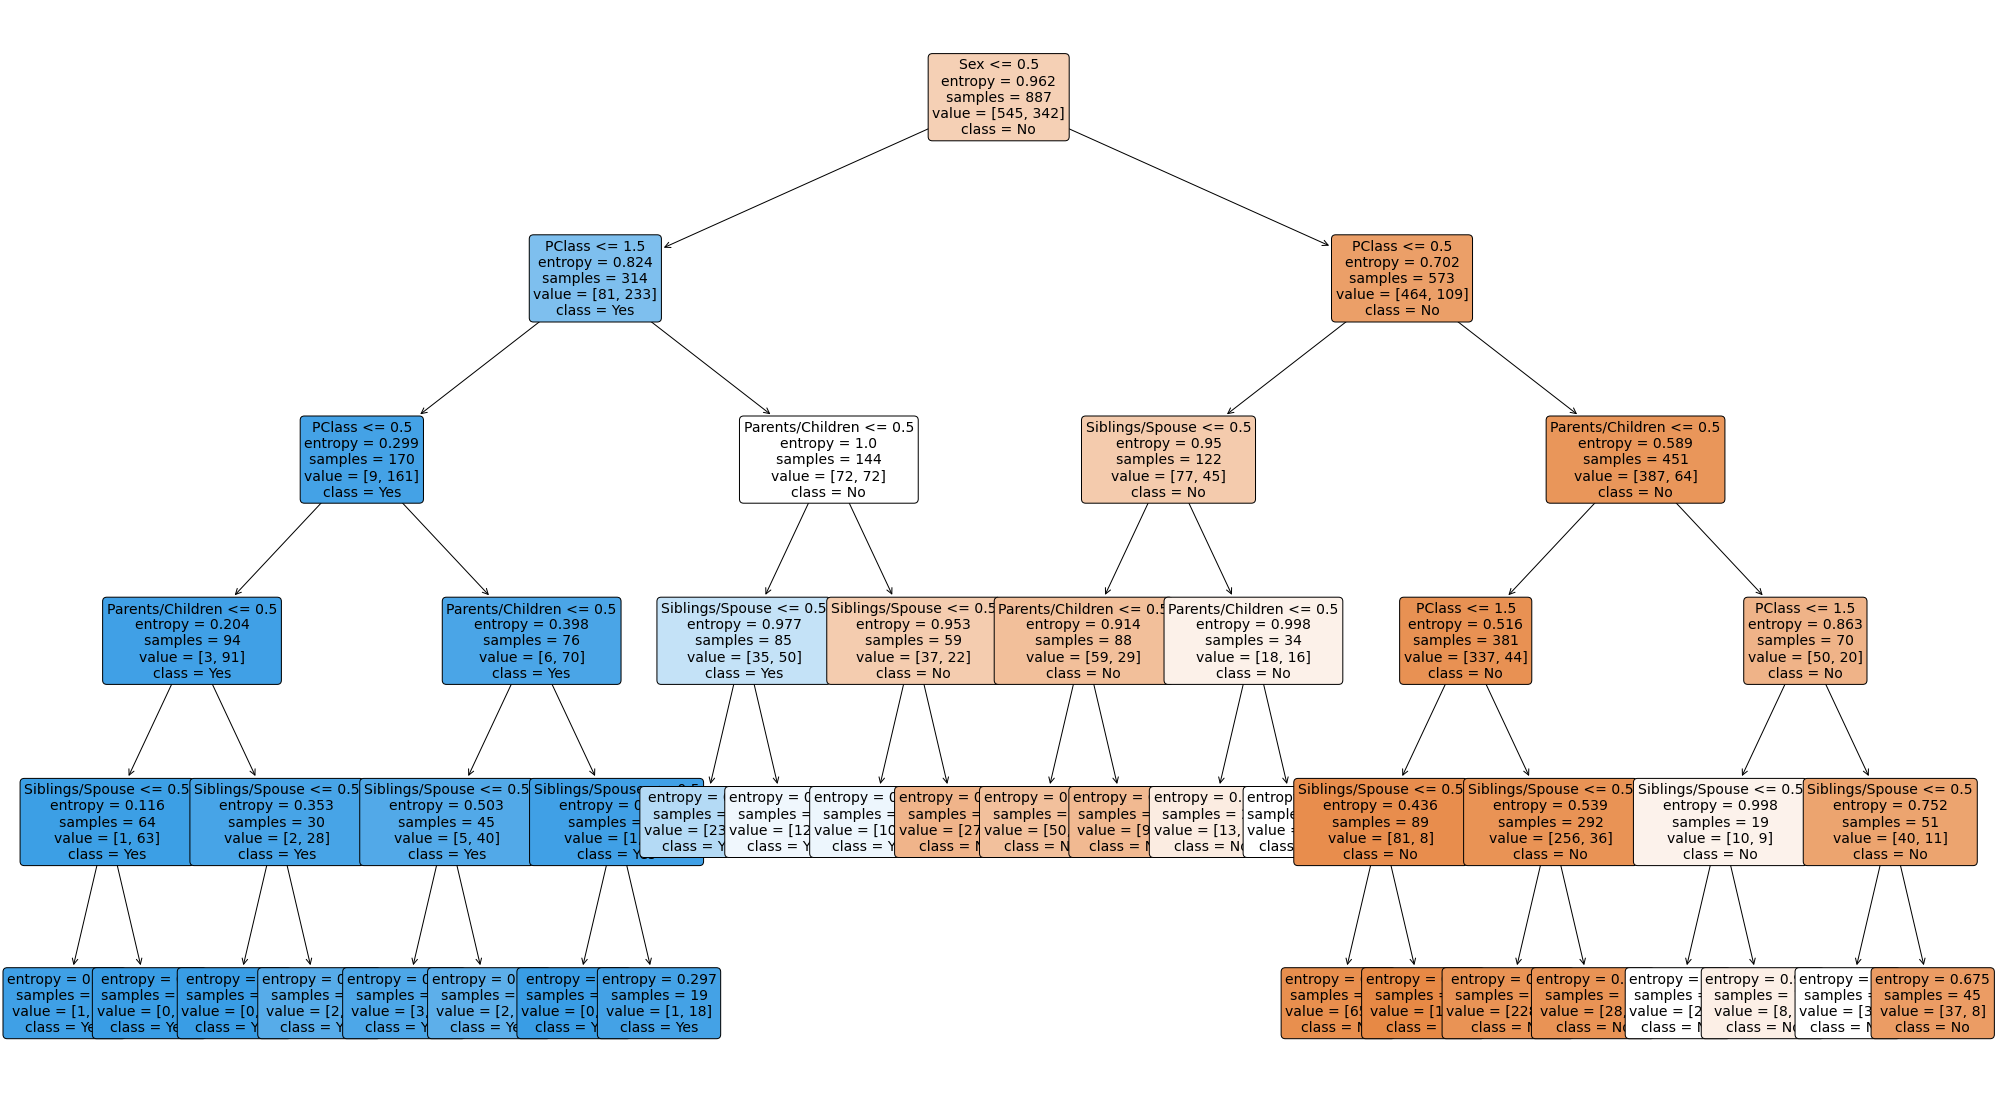

In [11]:
plt.figure(figsize=(35,20))
a = plot_tree(clf, 
              feature_names=columnNames, 
              class_names=['No','Yes'], 
              filled=True, 
              rounded=True, 
              fontsize=14)

In [14]:
y_pred_sklearn =clf.predict(data[:,:4])

In [15]:
getErrorRate(y_pred_sklearn,data[:,4])

-0.07440811724915446